Part A: Linear Classification Models

Part B: Neural Network Implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleFNN(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)
        # --- Weight Initialization ---
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
import torchvision
import torchvision.transforms as transforms

# Define the transform: Convert images to PyTorch Tensors
transform = transforms.ToTensor()
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train=DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test=DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
import torch.optim as optim


model = SimpleFNN()
model.to(device)

loss=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [18]:
NUM_EPOCHS = 12
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images,labels in train:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)

        l=loss(outputs,labels)
        l.backward()
        optimizer.step()
        
        running_loss += l.item()
        # Get training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
   
    epoch_loss = running_loss / len(train)
    train_loss_history.append(epoch_loss)
    epoch_train_acc = 100 * train_correct / train_total
    train_acc_history.append(epoch_train_acc)


    model.eval() 
    correct = 0
    total = 0
    val_running_loss = 0.0

    with torch.no_grad(): 
        for images, labels in test: 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            l= loss(outputs, labels) 
            val_running_loss += l.item()
            correct+=(predicted==labels).sum().item()

    epoch_val_loss = val_running_loss / len(test)
    epoch_val_acc = 100 * correct / total

    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
      f'Train Loss: {epoch_loss:.4f}, '
      f'Train Acc: {epoch_train_acc:.2f}%, '
      f'Val Loss: {epoch_val_loss:.4f}, '
      f'Val Acc: {epoch_val_acc:.2f}%')

Epoch [1/12], Train Loss: 0.3195, Train Acc: 90.48%, Val Loss: 0.1674, Val Acc: 95.02%
Epoch [2/12], Train Loss: 0.1389, Train Acc: 95.87%, Val Loss: 0.1255, Val Acc: 96.21%
Epoch [3/12], Train Loss: 0.0992, Train Acc: 97.04%, Val Loss: 0.0979, Val Acc: 96.82%
Epoch [4/12], Train Loss: 0.0773, Train Acc: 97.67%, Val Loss: 0.0954, Val Acc: 96.90%
Epoch [5/12], Train Loss: 0.0636, Train Acc: 98.09%, Val Loss: 0.0878, Val Acc: 97.21%
Epoch [6/12], Train Loss: 0.0530, Train Acc: 98.41%, Val Loss: 0.0709, Val Acc: 97.70%
Epoch [7/12], Train Loss: 0.0443, Train Acc: 98.65%, Val Loss: 0.0776, Val Acc: 97.51%
Epoch [8/12], Train Loss: 0.0375, Train Acc: 98.84%, Val Loss: 0.0727, Val Acc: 97.67%
Epoch [9/12], Train Loss: 0.0307, Train Acc: 99.09%, Val Loss: 0.0738, Val Acc: 97.61%
Epoch [10/12], Train Loss: 0.0251, Train Acc: 99.28%, Val Loss: 0.0707, Val Acc: 97.84%
Epoch [11/12], Train Loss: 0.0224, Train Acc: 99.40%, Val Loss: 0.0786, Val Acc: 97.70%
Epoch [12/12], Train Loss: 0.0178, Train 

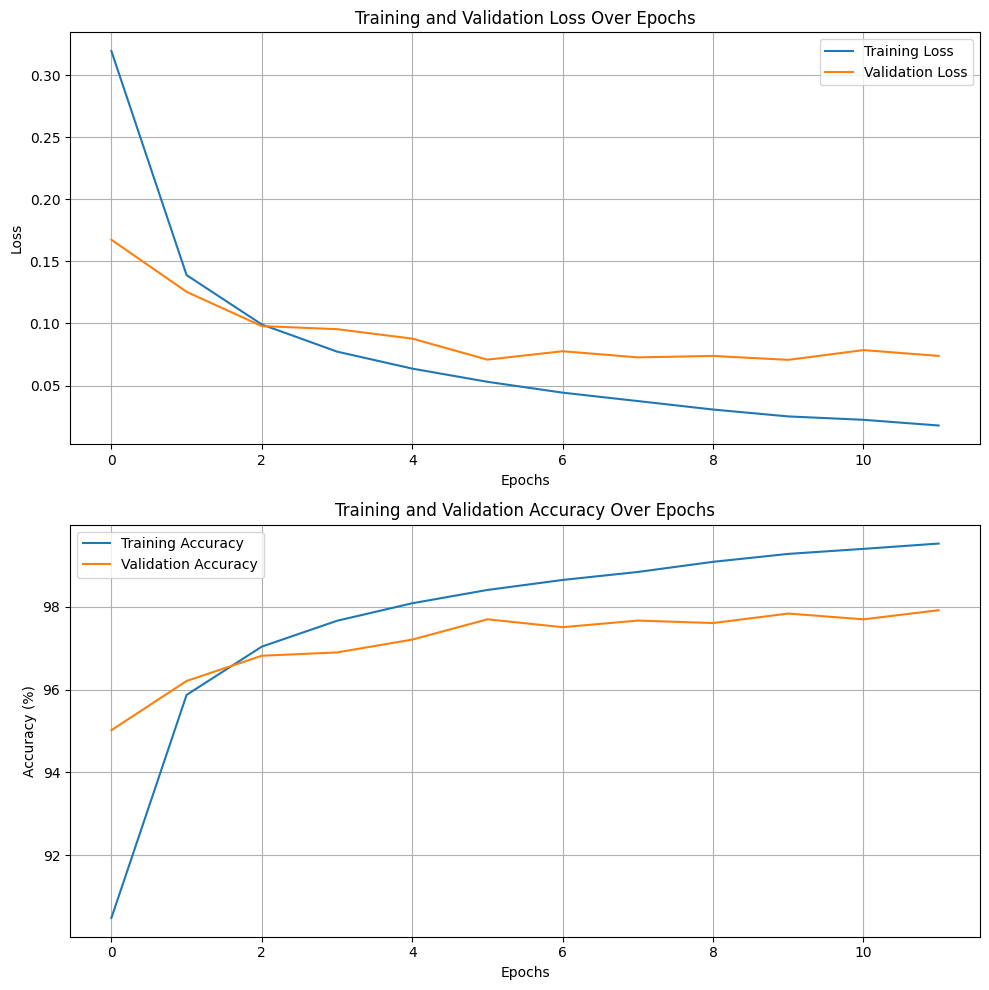

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Training & Validation Loss
ax1.plot(train_loss_history, label='Training Loss')
ax1.plot(val_loss_history, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()
ax1.grid(True)

# Plot 2: Training & Validation Accuracy
ax2.plot(train_acc_history, label='Training Accuracy')
ax2.plot(val_acc_history, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy Over Epochs')
ax2.legend()
ax2.grid(True)


plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

Part C: Comprehensive Analysis

Part D: Advanced Techniques